In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Import own library with custom technical routines
from custom_routines import custom_routines as cr

## 1. 

In [72]:
train_df = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/juegos_entrenamiento.txt", header=None, delim_whitespace=True)
train_df.insert(0,0,list(np.ones(len(train_df))), True)
train_data = train_df.values
print(train_data[:5])

[[ 1.  3.  4.  1.]
 [ 1.  7.  8.  1.]
 [ 1. 40. 10.  1.]
 [ 1. 16. 17.  1.]
 [ 1.  8. 18.  1.]]


In [73]:
test_df = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/juegos_validacion.txt", header=None, delim_whitespace=True)
test_df.insert(0,0,list(np.ones(len(test_df))), True)
test_data = test_df.values
print(test_data[:5])

[[  1.  35.  43.   1.]
 [  1.  45.   9.   0.]
 [  1.  55. 106.   0.]
 [  1.  35.  43.   1.]
 [  1.  35.  43.   1.]]


In [74]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories = 'auto')
enc.fit(np.concatenate((train_data[0:,:-1], test_data[0:,:-1])))


# One-hot-encoding para los datos de entrenamiento
train_features_enc = enc.transform(train_data[0:,:-1]).toarray()
train_responses = train_data[0:,-1]
print(len(train_features_enc[0]),len(train_responses))

# One-hot-encoding para los datos de validación
test_features_enc = enc.transform(test_data[0:,:-1]).toarray()
test_responses = test_data[0:,-1]
print(len(test_features_enc[0]),len(test_responses))

245 319
245 115


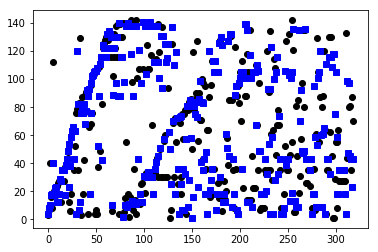

In [114]:
plt.plot(train_df.iloc[0:,1],'ko')
plt.plot(train_df.iloc[0:,2],'bs')

In [115]:
#Training an Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

gaussian_classifier = GaussianNB()
gaussian_classifier.fit(train_features_enc, train_responses)
print(gaussian_classifier.score(train_features_enc,train_responses))
print(gaussian_classifier.score(test_features_enc, test_responses))

0.8432601880877743
0.7478260869565218


In [116]:
predicted_nb = gaussian_classifier.predict(test_features_enc)

l = len(predicted_nb)
falsepositive_nb = dict()
truepositive_nb = dict()
auc_nb = dict()

for i in range(0,m):
    falsepositive_nb[i], truepositive_nb[i], _ = roc_curve(test_responses, predicted_nb)
    auc_nb[i] = auc(falsepositive_nb[i], truepositive_nb[i])
    
# Compute area under ROC curve
falsepositive_nb["micro"], truepositive_nb["micro"], _ = roc_curve(test_responses.ravel(), predicted_nb.ravel())#  y_test.ravel(), y_score.ravel())
auc_nb["micro"] = auc(falsepositive_nb["micro"], truepositive_nb["micro"])

print("Área bajo la curva ROC =", auc_nb[2])

Área bajo la curva ROC = 0.6058758314855875


In [77]:
# Training an Multinomial Naive Bayes model
#from sklearn.naive_bayes import MultinomialNB

#multinomial_classifier = MultinomialNB()
#multinomial_classifier.fit(train_features_enc, train_responses)
#print(multinomial_classifier.score(train_features_enc, train_responses))
#print(multinomial_classifier.score(test_features_enc, test_responses))

In [117]:
from logisticReg import logistic_regression
logit_reg = logistic_regression()

logit_reg.fit(train_features_enc, train_responses, 0)
print(logit_reg.score(train_features_enc, train_responses))
print(logit_reg.score(test_features_enc, test_responses))

0.9247648902821317
0.6608695652173913


In [118]:
predicted_logit = logit_reg.predict(test_features_enc)
m = len(predicted_logit)
falsepositive_logit = dict()
truepositive_logit = dict()
auc_logit = dict()

for i in range(0,m):
    falsepositive_logit[i], truepositive_logit[i], _ = roc_curve(test_responses, predicted_logit)
    auc_logit[i] = auc(falsepositive_logit[i], truepositive_logit[i])
    
# Compute area under ROC curve
falsepositive_logit["micro"], truepositive_logit["micro"], _ = roc_curve(test_responses.ravel(), predicted_logit.ravel())#  y_test.ravel(), y_score.ravel())
auc_logit["micro"] = auc(falsepositive_logit["micro"], truepositive_logit["micro"])

print("Área bajo la curva ROC =", auc_logit[2])

Área bajo la curva ROC = 0.6535476718403548


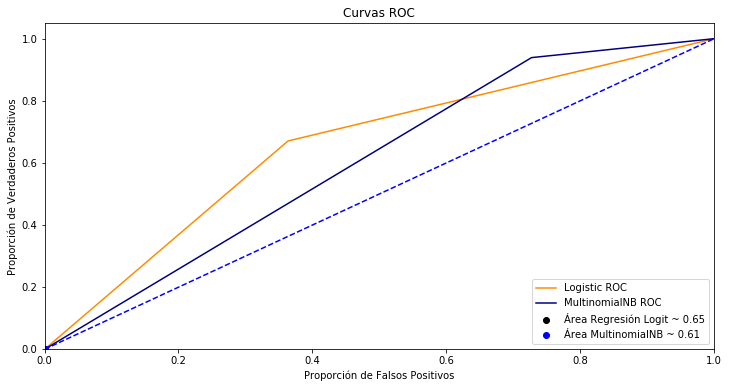

In [119]:
plt.figure(figsize=(12,6))
plt.title('Curvas ROC')
plt.plot(falsepositive_logit[2], truepositive_logit[2], color='darkorange', label='Logistic ROC')
plt.plot(falsepositive_nb[2], truepositive_nb[2], color='navy', label='MultinomialNB ROC')
plt.plot(0,0,'ko', label = 'Área Regresión Logit ~ %0.2f' % auc_logit[2])
plt.plot(0,0,'bo', label = 'Área MultinomialNB ~ %0.2f' % auc_nb[2])
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proporción de Falsos Positivos')
plt.ylabel('Proporción de Verdaderos Positivos')

plt.legend(loc = 'lower right')
plt.show()